**This jupyter notebook makes it possible to generate a sound (you can hear it) and superpose a a noise to it. Afterward, a filter is generated to remove (as much as possible) the noise. All sounds can be reproduced using the notebook.**


**Author**: Luca Giaccone (luca.giaccone@polito.it)<br>
**Date**: 7/11/2021<br>
**GitHub link**: [https://github.com/giaccone/pytool4teaching](https://github.com/giaccone/pytool4teaching)

In [1]:
# Load libraries
import IPython.display as ipd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from sympy import *
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider

# useful function to make the code more compact
def plot_sound(t, signal, xmax):
    plt.figure(figsize=(14, 5))
    plt.plot(t,signal)
    plt.xlabel('time (ms)',fontsize=16)
    plt.ylabel('signal',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(0, xmax)
    
def sym2lti(H):
    num, den = simplify(H).as_numer_denom()
    p_num_den = poly(num, s), poly(den, s)  # polynomials
    c_num_den = [p.all_coeffs() for p in p_num_den]
    l_num, l_den = [lambdify((), c)() for c in c_num_den]
    H = signal.lti(l_num, l_den)
    return H, l_num, l_den

# <center>build signal, 440 Hz, 2 sec</center>

In [2]:
sr = 22050   # sample rate
T = 2.0      # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
f = 440  # frequency
sound = 0.5*np.sin(2*np.pi*f*t)

# or:
# sound, sr = librosa.load('piano_A4.wav')

# <center> plot the signal </center>

In [3]:
makeplot = lambda xmax: plot_sound(t*1e3, sound, xmax)
interact(makeplot, xmax=FloatSlider(min=10, max=2000, step=10, continuous_update=False, value=2000));

interactive(children=(FloatSlider(value=2000.0, continuous_update=False, description='xmax', max=2000.0, min=1…

# <center>can we hear the signal?</center>

In [4]:
# play sound
ipd.Audio(sound, rate=sr)

In [5]:
# add random noise
noise = (np.random.random(sound.shape)- 0.5) * np.max(sound)
noisy_sound = sound + noise

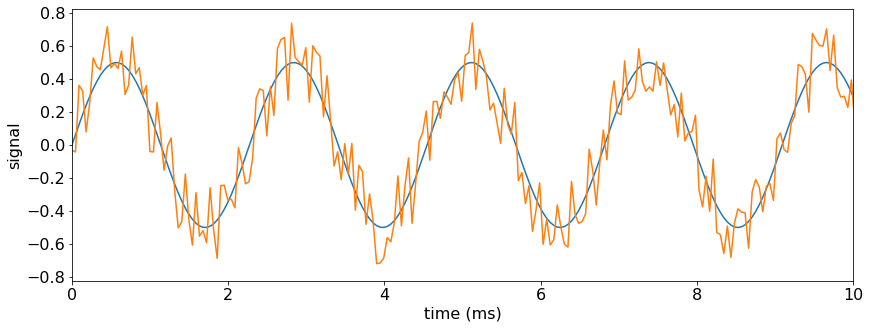

In [6]:
plot_sound(t*1e3, sound,xmax=10)
plt.plot(t*1e3, noisy_sound)

In [7]:
# play sound
ipd.Audio(noisy_sound, rate=sr)

# <center>design the filter</center>

In [8]:
# cutoff frequency
f0 = 2*f;

# Circuit constants
R1 = 1e3;
R2 = 100e3;
R3 = 10000e3;

$\omega_0 = \dfrac{1}{RC} \Rightarrow C = \dfrac{1}{\omega_0 R} = \dfrac{1}{2  \pi  f_0 R}$

In [9]:
C1 = 1/(2*np.pi*f0*R1);
C2 = 1/(2*np.pi*f0*R2);
C3 = 1/(2*np.pi*f0*R3);

s = Symbol('s')
H1 = 1 / (1 + s * R1 * C1); # s = jw
H2 = 1 / (1 + s * R2 * C2);
H3 = 1 / (1 + s * R3 * C3);

# create a 3rd order filter
H = H1 * H2 * H3

In [10]:
H

(0.000180857889877154*s + 1)**(-3)

In [11]:
# from symbolic expression to LTI system
H, num, den = sym2lti(H)

## bode plot

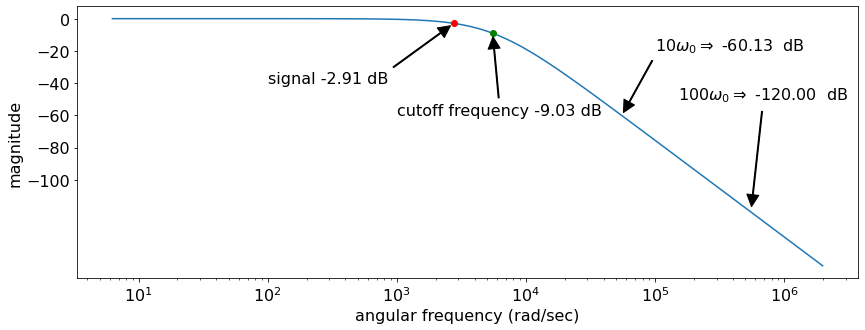

In [12]:
freq = np.logspace(0, 5.5,100)
w = 2 * np.pi * freq
w, mag, phase = signal.bode(H,w)
w0, H0 = signal.freqresp(H, 2*np.pi*f0)
w1, H1 = signal.freqresp(H, 2*np.pi*f)
w10, H10 = signal.freqresp(H, 2*np.pi*10*f0)
w100, H100 = signal.freqresp(H, 2*np.pi*100*f0)

plt.figure(figsize=(14, 5))
plt.semilogx(w, mag)
plt.semilogx(w1, 20 * np.log10(np.abs(H1)),'ro')
plt.semilogx(w0, 20 * np.log10(np.abs(H0)),'go')
plt.xlabel('angular frequency (rad/sec)',fontsize=16)
plt.ylabel('magnitude',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yticks(range(-100,20,20))
plt.annotate('signal {:.2f} dB'.format(20 * np.log10(np.abs(H1[0]))), xy=(w1,20 * np.log10(np.abs(H1))),
             xytext=(100,-40), arrowprops=dict(facecolor='k', shrink=0.05, width=1), fontsize=16)

plt.annotate('cutoff frequency {:.2f} dB'.format(20 * np.log10(np.abs(H0[0]))),
             xy=(2*np.pi*f0,20 * np.log10(np.abs(H0))), xytext=(1000,-60),
            arrowprops=dict(facecolor='k', shrink=0.05, width=1), fontsize=16)

plt.annotate('$10\omega_0 \Rightarrow$ {:.2f}  dB'.format(20 * np.log10(np.abs(H10[0]))),
             xy=(w10,20 * np.log10(np.abs(H10))), xytext=(10e4,-20),
            arrowprops=dict(facecolor='k', shrink=0.05, width=1), fontsize=16)

plt.annotate('$100\omega_0 \Rightarrow$ {:.2f}  dB'.format(20 * np.log10(np.abs(H100[0]))),
             xy=(w100,20 * np.log10(np.abs(H100))), xytext=(15e4,-50),
            arrowprops=dict(facecolor='k', shrink=0.05, width=1), fontsize=16);


In [13]:
num, den, Ts = signal.cont2discrete((num, den), 1/sr)
filtered_sound = signal.lfilter(num.flatten(), den.flatten(), noisy_sound)

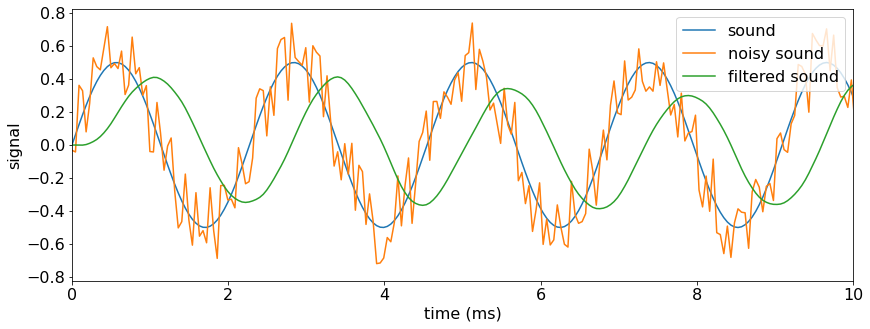

In [14]:
plot_sound(t*1e3, sound, xmax=10)
plt.plot(t*1e3, noisy_sound)
plt.plot(t*1e3, filtered_sound)
plt.legend(('sound', 'noisy sound', 'filtered sound'),fontsize=16)

In [15]:
# play all sounds
ipd.Audio(sound, rate=sr)

In [16]:
# play sound

ipd.Audio(noisy_sound, rate=sr)

In [17]:
# play sound
ipd.Audio(filtered_sound, rate=sr)